In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import numpy as np
import pandas as pd
import pickle
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

In [2]:
X = pd.read_csv('../data/processed/df_train.csv').iloc[::, :18:]
y= pd.read_csv('../data/processed/df_train.csv')['satisfaction']

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

In [4]:

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
scaler.inverse_transform(X_train)

array([[ 0., 50.,  1., ...,  1.,  0.,  0.],
       [ 1., 40.,  1., ...,  3.,  1.,  0.],
       [ 1., 38.,  1., ...,  3.,  1.,  0.],
       ...,
       [ 1., 35.,  0., ...,  3.,  0.,  1.],
       [ 1., 67.,  0., ...,  5.,  0.,  1.],
       [ 1., 24.,  0., ...,  5.,  0.,  1.]])

accuracy score:   0.8774072107727207
precision score:  0.8804071246819338
recall score:     0.9082902870691845
F1 score:         0.8941313771257086
ROC:              0.8723830784391938
------------------------------------------- 
classification report:       
---------------------------------------------       
                    precision    recall  f1-score   support

           0       0.87      0.84      0.85      8910
           1       0.88      0.91      0.89     11809

    accuracy                           0.88     20719
   macro avg       0.88      0.87      0.87     20719
weighted avg       0.88      0.88      0.88     20719



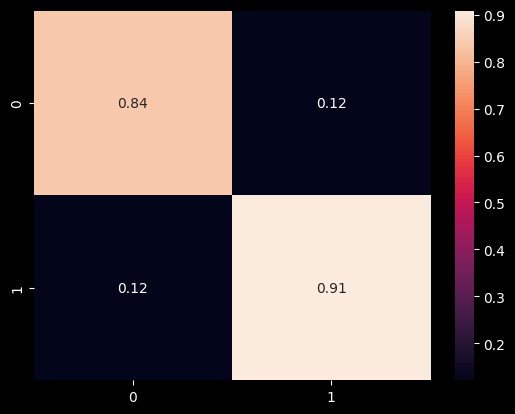

In [5]:
#me decante por solver saga que era más rápido
log_reg = LogisticRegression(solver='saga')

log_reg = log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

c_mat = confusion_matrix(y_test,y_pred)
c_mat

sns.heatmap(c_mat/c_mat.sum(axis=1), annot=True);
print(f'accuracy score:   {accuracy_score(y_test,y_pred)}')
print(f'precision score:  {precision_score(y_test, y_pred)}')
print(f'recall score:     {recall_score(y_test, y_pred)}')
print(f'F1 score:         {f1_score(y_test, y_pred)}')
print(f'ROC:              {roc_auc_score(y_test, y_pred)}')
print('------------------------------------------- ')
print(f'''classification report:       
---------------------------------------------       
      {classification_report(y_test, y_pred)}''')


In [21]:
pickle.dump(log_reg, open('../models/log_reg.pkl', 'wb')) 

In [7]:
result_reg_log = cross_val_score(log_reg, X_test, y_test, cv=10).mean()

result_reg_log

0.8776003749144744

In [8]:
model_reg_log = recall_score(y_test, y_pred)
model_reg_log

0.9082902870691845

In [18]:
with open('../data/variables_pkl/resultado_log_reg.pkl', 'wb') as resultado_log_reg:
    pickle.dump(('log_reg', 0.9082902870691845), resultado_log_reg)

In [10]:
name='Logistic Regression con validación cruzada'
kfold = KFold(n_splits=10, shuffle=True) #Parte los datos en 10 trozos para usar validación cruzada / cross validation
cv_results = cross_val_score(log_reg, X_train, y_train, cv=kfold, scoring='accuracy')

msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(cv_results)
print(msg)

[0.87379344 0.86920849 0.86751931 0.87524131 0.875      0.87595028
 0.8746229  0.87305418 0.87112345 0.86931338]
Logistic Regression con validación cruzada: 0.872483 (0.002826)


#### Feature Selection

In [11]:
from sklearn.feature_selection import SelectKBest, f_classif
x_data_kbest = SelectKBest(f_classif, k = 5).fit_transform(X_train, y_train)
x_data_kbest.shape

(82875, 5)

In [12]:
logit = LogisticRegression(random_state = 17)

In [13]:
cross_val_score(logit,
               X_test,
                y_test,
                scoring = 'roc_auc',
                cv = 5
               ).mean()

0.9281194425088051

In [14]:
cross_val_score(logit,
               x_data_kbest,
                y_train,
                scoring = 'roc_auc',
                cv = 5
               ).mean()

0.9040779200003213

In [15]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline


# Aplicamos la regresión logística usando el feature importance del random forest
# Por defecto calcula la media del feature importance y elige las que sean superiores a esa media

rf = RandomForestClassifier(n_estimators = 200, random_state = 17, max_depth=5)

pipe = make_pipeline(SelectFromModel(estimator=rf),
                    logit)

print('Reg. Log.', cross_val_score(logit, X_train,y_train,
                                  scoring='roc_auc',cv=5).mean())

print('Random Forest', cross_val_score(rf,  X_train,y_train,
                                  scoring='roc_auc',cv=5).mean())

print('Reg. Log. con selección RF', cross_val_score(pipe,  X_train,y_train,
                                  scoring='roc_auc',cv=5).mean())

Reg. Log. 0.9245304638154769
Random Forest 0.9741779309713998
Reg. Log. con selección RF 0.9079532519092378


In [22]:
pickle.dump(pipe, open('../models/log_reg_rf.pkl', 'wb')) 

In [23]:
pipe

Pipeline(steps=[('selectfrommodel',
                 SelectFromModel(estimator=RandomForestClassifier(max_depth=5,
                                                                  n_estimators=200,
                                                                  random_state=17))),
                ('logisticregression', LogisticRegression(random_state=17))])

In [16]:
print('Reg. Log. con selección RF', cross_val_score(pipe,  X_test,y_test, scoring='roc_auc',cv=5).mean())

Reg. Log. con selección RF 0.9111703914398241


In [19]:
with open('../data/variables_pkl/resultado_log_reg_rf.pkl', 'wb') as resultado_log_reg_rf:
    pickle.dump(('log_regcon selección RF', 0.9111703914398241), resultado_log_reg_rf)